# Homework #3
### Jessica Birky

This homework is dedicated to my favorite faculty Mario Juric and Zeljko Ivezic

In [1]:
import numpy as np
from numpy.polynomial import polynomial as poly
import pandas as pd
from astropy.table import Table
from astropy.constants import G
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
import time

import astroML
print(astroML.__version__)
print(astroML.__path__)
from astroML.lumfunc import bootstrap_Cminus

1.0.1
['/home/jbirky/.conda/envs/astro/lib/python3.7/site-packages/astroML-1.0.2-py3.7.egg/astroML']


## Problem A

In [2]:
obs = pd.read_csv('../homeworks/LSSTsimWDobs60.dat', delim_whitespace=True)
tru = pd.read_csv('../homeworks/LSSTsimWDtruth60.dat', delim_whitespace=True)

obs.reset_index(inplace=True)
obs.columns = ['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs', 'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs', 'muDecObs', 'muErr']

In [3]:
obs.head()

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,zObs,zErr,yObs,yErr,piObs,piErr,muRAObs,muDecObs,muErr
0,183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,23.127,0.013,23.408,0.048,1.02,0.91,-1.60,-6.76,0.32
1,183.261,-1.25781,25.574,0.106,25.173,0.024,25.251,0.022,25.338,0.046,25.570,0.112,25.723,0.400,1.17,8.95,-3.19,-9.73,3.09
2,183.038,-1.32316,24.688,0.050,24.341,0.012,24.302,0.010,24.356,0.019,24.442,0.042,24.845,0.140,2.90,3.84,1.84,0.17,1.32
3,183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,22.966,0.012,23.066,0.035,0.24,1.11,-12.58,3.17,0.38
4,183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,23.034,0.012,23.088,0.036,-0.23,1.22,-8.69,-10.08,0.42


In [4]:
tru.head()

,ra,dec,u,g,r,i,z,y,Mr,logg,vR,vPhi,vZ,T,P
0,183.487,-1.36738,22.454,22.269,22.566,22.846,23.133,23.420,11.338,8.0,-50.89,-134.57,40.51,1,1
1,183.261,-1.25781,25.549,25.183,25.235,25.364,25.546,25.729,12.346,8.0,-51.56,-53.51,-3.59,1,1
2,183.038,-1.32316,24.718,24.354,24.301,24.356,24.471,24.587,12.867,8.0,-47.11,-170.19,94.17,1,1
3,183.127,-1.13602,23.288,22.913,22.834,22.871,22.972,23.073,12.989,8.0,29.71,-196.22,33.81,1,1
4,183.339,-1.39733,23.517,23.099,22.959,22.960,23.030,23.100,13.249,8.0,-4.74,-187.17,-37.27,1,1


In [5]:
# Compute distance modulii
obs['snr'] = obs['piObs']/obs['piErr']
obs['dist'] = 1/obs['piObs']
obs['dMod'] = 5 * np.log10(obs['dist'] * 1000) - 5

tru['dMod'] = tru['r'] - tru['Mr']

# SNR cut
good_snr = obs['snr'] > 10
gold_obs = obs[good_snr]
gold_tru = tru[good_snr]

/home/jbirky/.conda/envs/astro/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


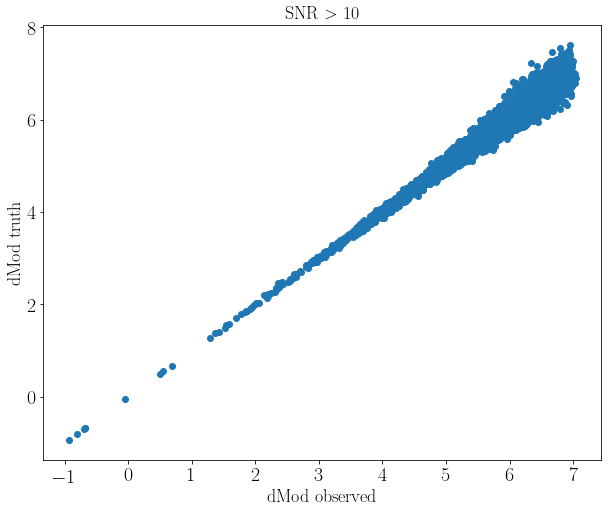

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


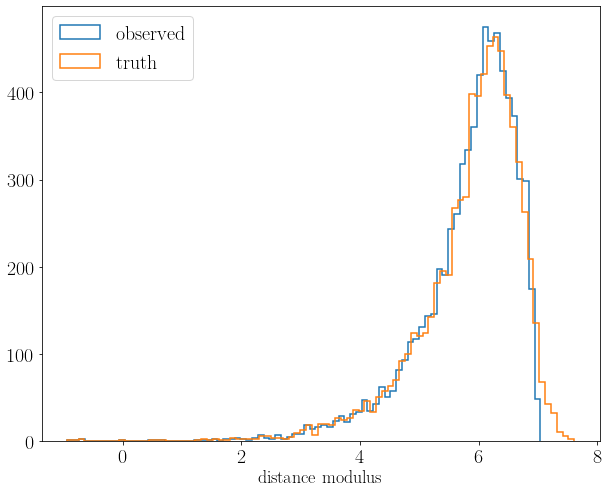

In [6]:
plt.figure(figsize=[10,8])
plt.scatter(gold_obs['dMod'], gold_tru['dMod'])
plt.xlabel('dMod observed', fontsize=18)
plt.ylabel('dMod truth', fontsize=18)
plt.title(r'SNR $>$ 10', fontsize=18)
plt.show()

plt.figure(figsize=[10,8])
plt.hist(gold_obs['dMod'], histtype='step', bins='fd', linewidth=1.5, label='observed')
plt.hist(gold_tru['dMod'], histtype='step', bins='fd', linewidth=1.5, label='truth')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('distance modulus', fontsize=18)
plt.show()

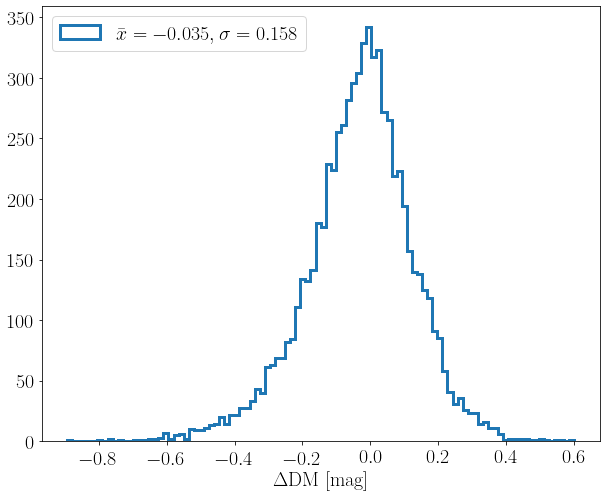

In [7]:
dModDiff = gold_obs['dMod'] - gold_tru['dMod']

summary = r'$\bar{x}=%.3f, \sigma=%.3f$'%(np.mean(dModDiff), np.std(dModDiff))

plt.figure(figsize=[10,8])
plt.hist(dModDiff, bins=100, histtype='step', linewidth=3, label=summary)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'$\Delta$DM [mag]', fontsize=20)
plt.show()

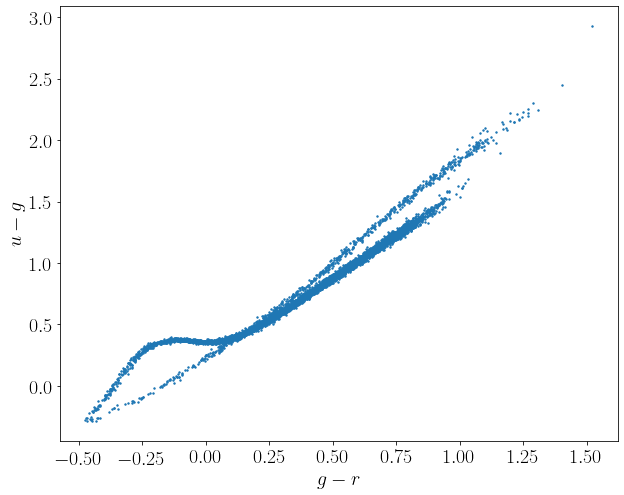

In [8]:
g_r = gold_obs['gObs'] - gold_obs['rObs']
u_g = gold_obs['uObs'] - gold_obs['gObs']

plt.figure(figsize=[10,8])
plt.scatter(g_r, u_g, s=2)
plt.xlabel(r'$g-r$', fontsize=20)
plt.ylabel(r'$u-g$', fontsize=20)
plt.show()

## Problem B

In [9]:
hwd = gold_obs[gold_tru['T'] == 1]
hwd.head()

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,...,yObs,yErr,piObs,piErr,muRAObs,muDecObs,muErr,snr,dist,dMod
47,182.148,-0.912051,20.983,0.006,20.560,0.005,20.419,0.005,20.401,0.005,...,20.537,0.006,4.49,0.42,-33.19,-4.44,0.15,10.690476,0.222717,6.738768
298,180.770,-0.454785,21.263,0.006,20.613,0.005,20.271,0.005,20.160,0.005,...,20.139,0.006,5.31,0.42,-22.58,-43.30,0.14,12.642857,0.188324,6.374527
417,179.769,0.725602,18.446,0.005,18.134,0.005,18.343,0.005,18.592,0.005,...,19.118,0.005,4.73,0.39,-42.27,-5.87,0.14,12.128205,0.211416,6.625694
515,180.119,0.388264,21.383,0.006,20.470,0.005,19.927,0.005,19.735,0.005,...,19.575,0.005,7.67,0.41,-60.25,-126.73,0.14,18.707317,0.130378,5.576023
555,179.925,0.145095,22.171,0.008,21.055,0.005,20.381,0.005,20.112,0.005,...,19.824,0.005,8.13,0.42,8.06,-0.75,0.15,19.357143,0.123001,5.449547


In [10]:
hwd['Mobs'] = hwd['rObs'] - hwd['dMod']
hwd['g_r']  = hwd['gObs'] - hwd['rObs']

color_bins = np.arange(-.5, 1.1, .1)
median_Mr = np.zeros(color_bins.shape[0])
for i, cbin in enumerate(color_bins):
    bin_sources = hwd[hwd['g_r'] > cbin-.05][hwd['g_r'] < cbin+.05]
    median_Mr[i] = np.median(bin_sources['Mobs'])

/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [12]:
x, y = color_bins, median_Mr

deg = 2
coeff2 = poly.polyfit(x, y, deg)
ypred2 = poly.Polynomial(coeff2)(x)
mse2 = np.sum((y - ypred2)**2)

deg = 3
coeff3 = poly.polyfit(x, y, deg)
ypred3 = poly.Polynomial(coeff3)(x)
mse3 = np.sum((y - ypred3)**2)

deg = 4
coeff4 = poly.polyfit(x, y, deg)
ypred4 = poly.Polynomial(coeff4)(x)
mse4 = np.sum((y - ypred4)**2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


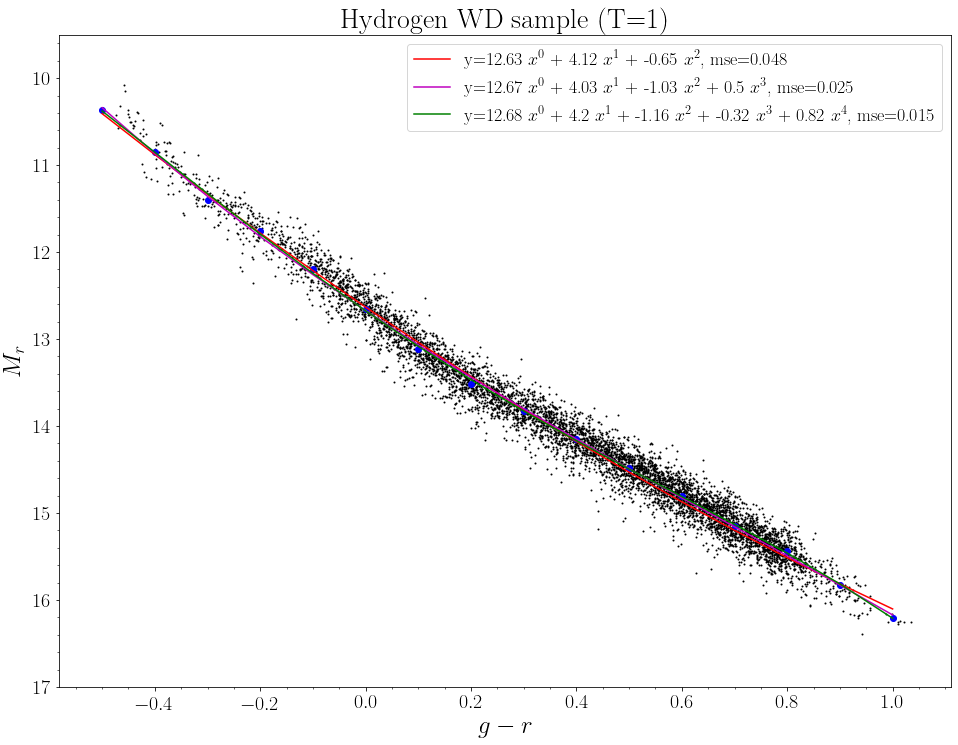

In [13]:
lbl2 = 'y=' + ' + '.join([r'%s $x^%s$'%(np.round(coeff2[i],2), i) for i in range(len(coeff2))]) + ', mse=%.3f'%(mse2)
lbl3 = 'y=' + ' + '.join([r'%s $x^%s$'%(np.round(coeff3[i],2), i) for i in range(len(coeff3))]) + ', mse=%.3f'%(mse3)
lbl4 = 'y=' + ' + '.join([r'%s $x^%s$'%(np.round(coeff4[i],2), i) for i in range(len(coeff4))]) + ', mse=%.3f'%(mse4)

plt.figure(figsize=[16,12])
plt.scatter(hwd['g_r'], hwd['Mobs'], s=1, color='k') 
plt.scatter(color_bins, median_Mr, color='b')
plt.plot(x, ypred2, color='r', label=lbl2)
plt.plot(x, ypred3, color='m', label=lbl3)
plt.plot(x, ypred4, color='g', label=lbl4)
plt.xlabel(r'$g-r$', fontsize=25)
plt.ylabel(r'$M_r$', fontsize=25)
plt.title('Hydrogen WD sample (T=1)', fontsize=28)
plt.legend(loc='upper right', fontsize=18)
plt.minorticks_on()
plt.ylim([17, 9.5])
plt.savefig('plots3/probB_fit.png')
plt.show()

## Problem C

In [14]:
pm_samp = obs[obs['rObs'] < 24.5]
pm_samp_tru = tru[tru['r'] < 24.5]

pm_samp['g_r'] = pm_samp['gObs'] - pm_samp['rObs']
pm_samp.keys()

/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       'muDecObs', 'muErr', 'snr', 'dist', 'dMod', 'g_r'],
      dtype='object')

In [15]:
pm_samp['mu_tot'] = np.sqrt(pm_samp['muRAObs']**2 + pm_samp['muDecObs']**2)
pm_samp['mu_snr'] = pm_samp['mu_tot'] / pm_samp['muErr']

gold_pm = pm_samp[pm_samp['mu_snr'] > 3]

print('Percent of sample with SNR > 3:', len(gold_pm) / len(pm_samp) * 100)

Percent of sample with SNR > 3: 97.53060074306319


/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Apply your photometric parallax relation from B to estimate Mr and distance

/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

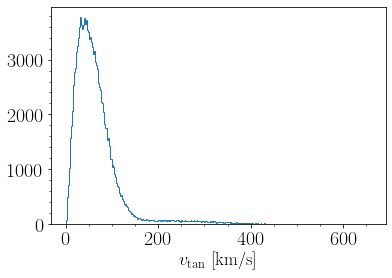

In [16]:
gold_pm['Mr_est'] = poly.Polynomial(coeff2)(gold_pm['g_r'])
gold_pm['dist_est'] = 10**((gold_pm['rObs'] - gold_pm['Mr_est'])/5 + 1)

# convert mu_tot (proper motion) from milliarcsec/yr to vtan (tangential velocity) km/s
radian_per_milliarcsec = np.pi/(180*1e3*3600)
km_per_pc = 3.086e13
sec_per_yr = 365*24*3600

gold_pm['vtan'] = (gold_pm['mu_tot'] * radian_per_milliarcsec) * gold_pm['dist_est'] * km_per_pc / sec_per_yr

# ===============================================
# plot distribution of tangential velocities

plt.hist(gold_pm['vtan'], bins='fd', histtype='step')
plt.xlabel(r'$v_{\rm tan}$ [km/s]', fontsize=18)
plt.minorticks_on()
plt.show()

In [17]:
# True number of disk and halo stars, rObs < 24.5
disk_ind = np.where(pm_samp_tru['P'] == 1)[0]
halo_ind = np.where(pm_samp_tru['P'] == 2)[0]

ndisk = len(disk_ind)
nhalo = len(halo_ind)
ntotal = ndisk + nhalo

ndisk, nhalo, ntotal

(173108, 9637, 182745)

#### Estimate disk and halo sample completeness and contamination for varying values of $v_{\rm tan}^{\rm cutoff}$

In [18]:
disk_comp, halo_comp = [], []
disk_cont, halo_cont = [], []

vcut_values = np.arange(0,510,20)

for vcut in vcut_values:
    disk_sel = gold_pm[gold_pm['vtan'] < vcut]
    halo_sel = gold_pm[gold_pm['vtan'] > vcut]

    disk_comp.append(len(disk_sel) / ntotal)
    halo_comp.append(len(halo_sel) / ntotal)
    
    disk_cont.append(len(set(disk_sel.index) & set(halo_ind)) / ntotal)
    halo_cont.append(len(set(halo_sel.index) & set(disk_ind)) / ntotal)

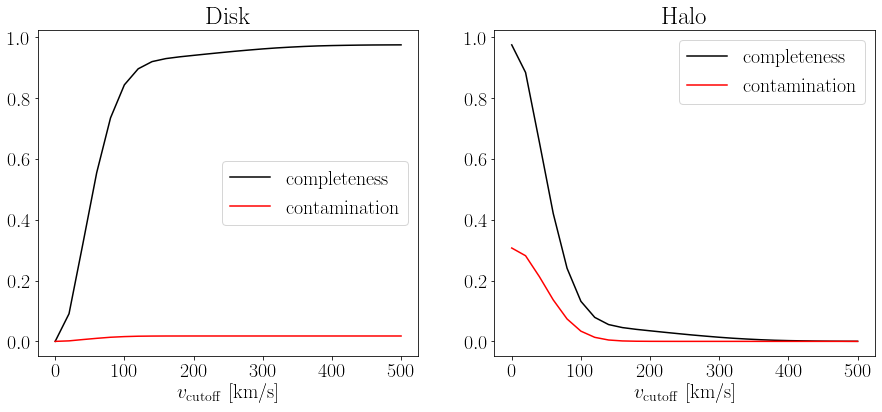

In [19]:
fig, axs = plt.subplots(1,2, figsize=[15,6])
axs[0].plot(vcut_values, disk_comp, color='k', label='completeness')
axs[1].plot(vcut_values, halo_comp, color='k', label='completeness')

axs[0].plot(vcut_values, disk_cont, color='r', label='contamination')
axs[1].plot(vcut_values, halo_cont, color='r', label='contamination')

axs[0].set_title('Disk', fontsize=25)
axs[1].set_title('Halo', fontsize=25)
axs[0].set_xlabel(r'$v_{\rm cutoff}$ [km/s]', fontsize=20)
axs[1].set_xlabel(r'$v_{\rm cutoff}$ [km/s]', fontsize=20)
axs[0].legend(loc='best', fontsize=20)
axs[1].legend(loc='best', fontsize=20)
plt.show()

## Problem D

https://www.astroml.org/book_figures/chapter4/fig_lyndenbell_toy.html

Using the “gold proper motion sample” from C, define a candidate disk sample by vtan < 150 km/s, and a candidate halo sample by vtan > 200
km/s. 

Using your results from C, estimate the completeness and contamination for each subsample

In [32]:
cand_disk = gold_pm[gold_pm['vtan'] < 150][gold_pm['g_r'] > -0.4][gold_pm['g_r'] < 1.0]
cand_halo = gold_pm[gold_pm['vtan'] > 200][gold_pm['g_r'] > -0.4][gold_pm['g_r'] < 1.0]

# drop columns from part A to avoid confusion
cand_disk = cand_disk.drop(columns=['dMod', 'dist'])
cand_halo = cand_halo.drop(columns=['dMod', 'dist'])

# distance modulus from Mr computed in part C
cand_disk['DM'] = cand_disk['rObs'] - cand_disk['Mr_est']
cand_halo['DM'] = cand_halo['rObs'] - cand_halo['Mr_est']

# inputs for Cminus 
xD = np.array(cand_disk['DM'])
yD = np.array(cand_disk['Mr_est'])
xH = np.array(cand_halo['DM'])
yH = np.array(cand_halo['Mr_est'])

r_faint_limit = 24.5
xmaxD = r_faint_limit - xD
ymaxD = r_faint_limit - yD
xmaxH = r_faint_limit - xH
ymaxH = r_faint_limit - yH

x_fit = np.linspace(0, 15, 42)
y_fit = np.linspace(10, 17, 42)

len(cand_disk), len(cand_halo), len(gold_pm)

/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(166136, 6315, 178244)

In [21]:
cand_disk.keys()

Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       'muDecObs', 'muErr', 'snr', 'g_r', 'mu_tot', 'mu_snr', 'Mr_est',
       'dist_est', 'vtan', 'DM'],
      dtype='object')

In [22]:
cand_halo.keys()

Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       'muDecObs', 'muErr', 'snr', 'g_r', 'mu_tot', 'mu_snr', 'Mr_est',
       'dist_est', 'vtan', 'DM'],
      dtype='object')

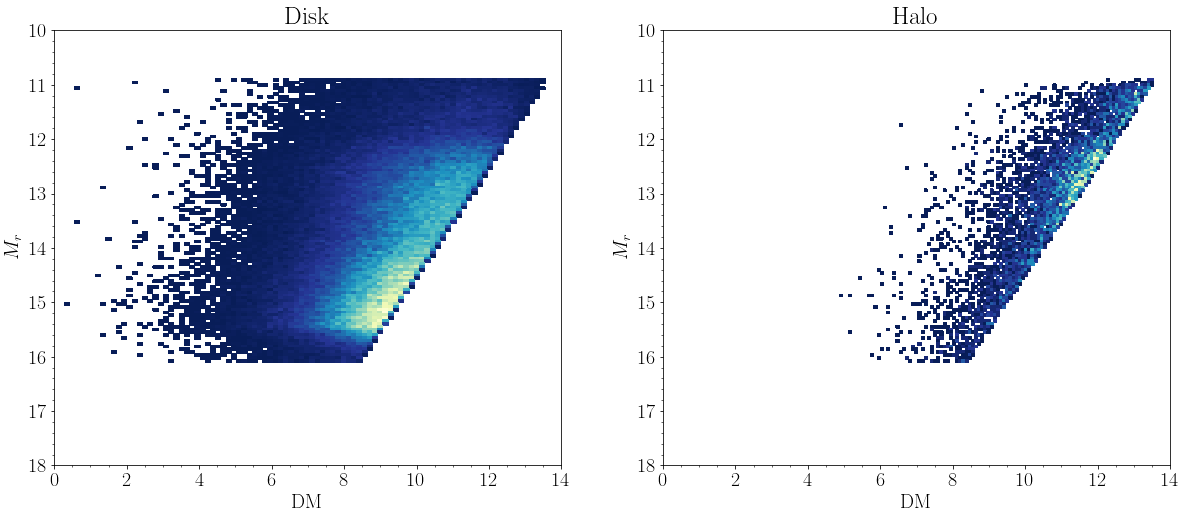

In [55]:
fig, ax = plt.subplots(1,2, figsize=[20,8])
ax[0].hist2d(xD, yD, bins=100, cmin=1, cmap='YlGnBu_r')
ax[1].hist2d(xH, yH, bins=100, cmin=1, cmap='YlGnBu_r')

ax[0].set_title('Disk', fontsize=25)
ax[1].set_title('Halo', fontsize=25)
ax[0].set_xlabel('DM', fontsize=20)
ax[1].set_xlabel('DM', fontsize=20)
ax[0].set_ylabel(r'$M_r$', fontsize=20)
ax[1].set_ylabel(r'$M_r$', fontsize=20)
ax[0].set_ylim([18, 10])
ax[1].set_ylim([18, 10])
ax[0].set_xlim([0, 14])
ax[1].set_xlim([0, 14])
ax[0].minorticks_on()
ax[1].minorticks_on()
plt.show()

In [87]:
t0 = time.time()

x_fit = np.linspace(0, 15, 42)
y_fit = np.linspace(10, 17, 42)

# compute the Cminus distributions (with bootstrap)
xD_dist, dxD_dist, yD_dist, dyD_dist = bootstrap_Cminus(xD, yD, xmaxD, ymaxD, x_fit, y_fit, Nbootstraps=15, normalize=True)
xH_dist, dxH_dist, yH_dist, dyH_dist = bootstrap_Cminus(xH, yH, xmaxH, ymaxH, x_fit, y_fit, Nbootstraps=15, normalize=True)

tf = time.time() - t0
print('time (s): %.2f, time (min): %.2f'%(tf, tf/60))

# =======================================

np.savez('results/cminus_disk_results.npz',
         xD_dist=xD_dist, dxD_dist=dxD_dist,
         yD_dist=yD_dist, dyD_dist=dyD_dist)

np.savez('results/cminus_halo_results.npz',
         xH_dist=xH_dist, dxH_dist=dxH_dist,
         yH_dist=yH_dist, dyH_dist=dyH_dist)

time (s): 547.13, time (min): 9.12


In [88]:
xD_dist

array([0.00000000e+000, 1.24364909e-128, 0.00000000e+000, 1.77612643e-114,
       0.00000000e+000, 7.59211891e-115, 9.00948349e-114, 2.66418967e-113,
       7.14483036e-112, 1.91575656e-110, 6.95296454e-109, 3.59084994e-105,
       4.92987350e-102, 1.22305120e-097, 1.21913093e-091, 6.49549776e-088,
       5.75577436e-081, 5.51441873e-076, 1.93751945e-068, 1.97236952e-061,
       6.84234651e-056, 2.70182890e-050, 5.31179105e-044, 1.77853411e-037,
       6.18041794e-031, 1.47863068e-024, 6.31418039e-018, 7.08020272e-012,
       2.74687428e-006, 1.23458012e-001, 9.47876908e-001, 9.50378237e-001,
       4.95979380e-001, 1.55999543e-001, 4.42679273e-002, 1.31903194e-002,
       2.15735104e-003, 2.29084227e-005, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

In [93]:
xH_dist

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.21777247e-69, 1.85840626e-55, 3.71800444e-55,
       1.11654562e-53, 1.19090566e-53, 1.64153050e-51, 1.69874287e-50,
       3.77278463e-48, 5.45266205e-39, 8.21054217e-33, 1.70596710e-26,
       2.69926738e-16, 4.02612260e-08, 1.43324160e-02, 5.65991188e-01,
       1.15924104e+00, 5.14732396e-01, 2.56425445e-01, 1.74697232e-01,
       4.79135764e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

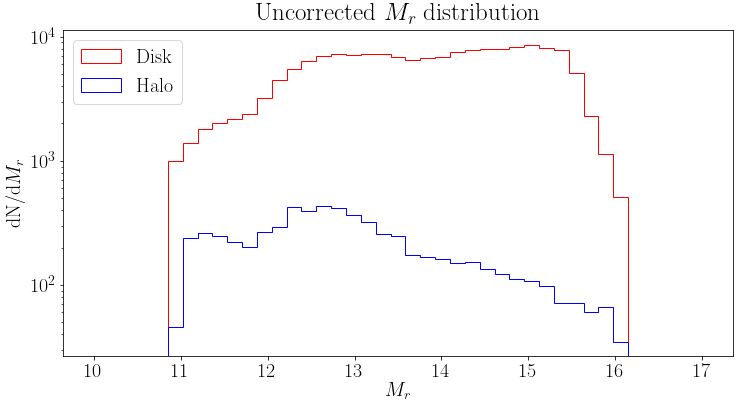

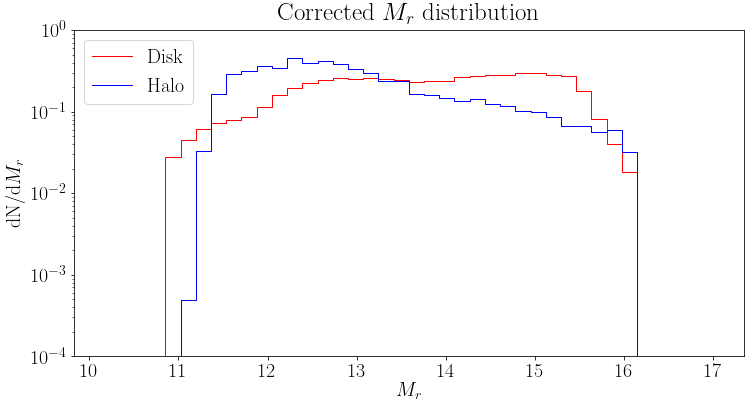

In [89]:
plt.figure(figsize=[12,6])
plt.hist(yD, histtype='step', bins=y_fit, color='r', label='Disk')
plt.hist(yH, histtype='step', bins=y_fit, color='b', label='Halo')
plt.yscale('log')
plt.xlabel(r'$M_r$', fontsize=20)
plt.ylabel(r'dN/d$M_r$', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.title(r'Uncorrected $M_r$ distribution', fontsize=25)
plt.show()

# =======================================
plt.figure(figsize=[12,6])
plt.step(x=y_fit[1:], y=yD_dist, color='r', linewidth=1, label='Disk')
plt.step(x=y_fit[1:], y=yH_dist, color='b', linewidth=1, label='Halo')

plt.yscale('log')
plt.xlabel(r'$M_r$', fontsize=20)
plt.ylabel(r'dN/d$M_r$', fontsize=20)
plt.ylim([1e-4,1])
plt.legend(loc='upper left', fontsize=20)
plt.title(r'Corrected $M_r$ distribution', fontsize=25)
plt.show()

In [82]:
# convert distance mod -> distance
cdist = 10**((x_fit / 5) + 1) 

# center distances and thickness
D_center = (cdist[1:] + cdist[:-1]) / 2
dD = (cdist[1:] - cdist[:-1]) 

# calculate volume slices
dOmega = 2*np.pi * (1 - np.sqrt(3)/2)
dV = dOmega * ((D_center + dD)**3 - dD**3) / 3

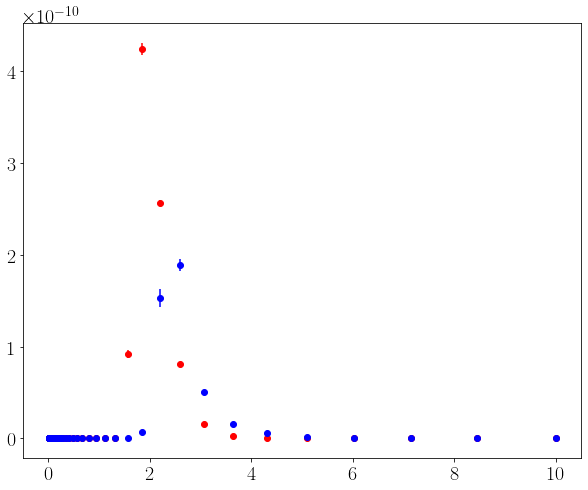

In [92]:
plt.figure(figsize=[10,8])
plt.errorbar(cdist[1:]/1e3, xD_dist/dV, yerr=dxD_dist/dV, marker='o', ls='none', label='Disk', color='r')
plt.errorbar(cdist[1:]/1e3, xH_dist/dV, yerr=dxH_dist/dV, marker='o', ls='none', label='Halo', color='b')
plt.show()

#### Compare reulsts to the true luminosity function

In [25]:
# LF is given in units of stars per pc3 and mag.
lf_disk = pd.read_csv('../homeworks/WDlumfuncDisk.dat', delim_whitespace=True)

# LF for halo white dwarfs produced using WDlumfuncDisk.dat
# and by making Mr fainter by 0.7 mag as per Chuck's suggestion
# IMPORTANT: divide LF by 200 to get proper normalization in 
# units of stars per pc3 and mag! 

lf_halo = pd.read_csv('../homeworks/WDlumfuncHalo.dat', delim_whitespace=True)
lf_halo['LF'] /= 200

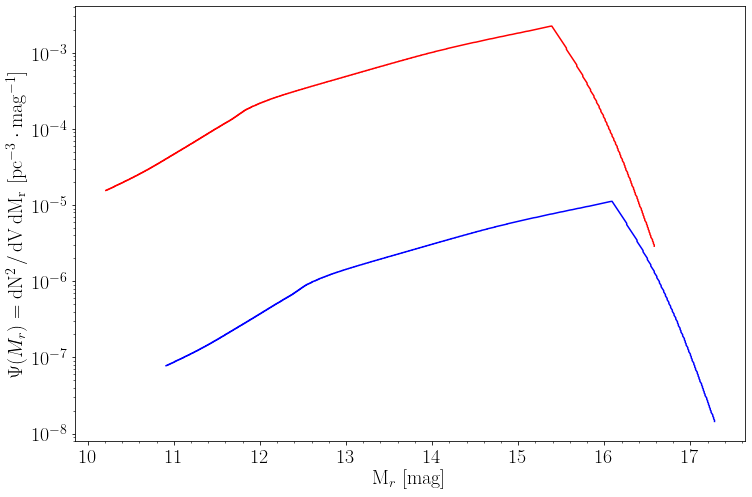

In [26]:
plt.figure(figsize=[12,8])
plt.plot(lf_disk['Mr'], lf_disk['LF'], color='r')
plt.plot(lf_halo['Mr'], lf_halo['LF'], color='b')
plt.yscale('log')
plt.xlabel(r'M$_r$ [mag]', fontsize=20)
plt.ylabel(r'$\Psi(M_r) = {\rm dN^2 \,/ \, dV \,dM_r \,\, [pc^{-3} \cdot mag^{-1}]}$', fontsize=20)
plt.minorticks_on()
plt.show()

## Problem E